# Image Segmentation Tutorial using Segmentation Model Library
**Author:** Nattapon Jaroenchai, University of Illinois Uraban-Champaign

Welcome to this tutorial on using the Segmentation Models library in Python. This library is a fantastic resource for anyone looking to build models for image segmentation tasks. It provides a simple, consistent interface for constructing models with a range of different architectures and pre-trained weights. This tutorial is designed to get you up and running with the Segmentation Models library and illustrate its power and flexibility.

In the world of computer vision, image segmentation plays a vital role. It is the process of partitioning a digital image into multiple segments to simplify and/or change the representation of an image into something more meaningful and easier to analyze. The Segmentation Models library simplifies the process of building and training state-of-the-art segmentation models, allowing you to focus on the more creative aspects of your project.

The tutorial will guide you through the following steps:

1. Importing the necessary libraries
2. Loading the dataset
3. Defining the model using the Unet architecture with an ImageNet backbone
4. Compiling and training the model
5. Plotting the training history

By the end of this tutorial, you should have a solid understanding of how to use the Segmentation Models library to construct your own segmentation models. Let's get started!

**Reqirements**

    keras >= 2.2.0 or tensorflow >= 1.13
    segmenation-models==1.0.*
    albumentations==0.3.0




## Create Folders Structures

We download all sample dataset and the neccessary libraries from github 

In [3]:
import os
input_data = './samples/'
model_path = './models/'
prediction_path = './predicts/'
log_path = './logs/'

# Create the folder if it does not exist
os.makedirs(input_data, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(prediction_path, exist_ok=True)
os.makedirs(log_path, exist_ok=True)

## Install segmentation models and neccesary libraries


In [5]:
%pip install keras tensorflow matplotlib segmentation-models scikit-learn scipy matplotlib 

## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from unet_util import dice_coef_loss, dice_coef, jacard_coef, dice_coef_loss, Residual_CNN_block, multiplication, attention_up_and_concatenate, multiplication2, attention_up_and_concatenate2, UNET_224, evaluate_prediction_result


sm.set_framework('tf.keras')
sm.framework()
tf.random.set_seed(180431)

# https://stackoverflow.com/questions/75433717/module-keras-utils-generic-utils-has-no-attribute-get-custom-objects-when-im
# open the file keras.py, change all the 'init_keras_custom_objects' to 'init_tfkeras_custom_objects'.
# the location of the keras.py is in the error message. In your case, it should be in /usr/local/lib/python3.8/dist-packages/efficientnet/

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## Load the sample dataset



In [4]:
X_train = np.load(input_data+'/train_data.npy').astype(np.float32) #50 samples
Y_train = np.load(input_data+'/train_label.npy').astype(np.float32)
X_validation = np.load(input_data+'/vali_data.npy').astype(np.float32) #20 samples
Y_validation = np.load(input_data+'/vali_label.npy').astype(np.float32)
X_test = np.load(input_data+'/test_data.npy').astype(np.float32) # 50 samples
Y_test = np.load(input_data+'/test_label.npy').astype(np.float32)

### Explore the data

The study utilizes eight raster layers for analysis and modeling. These layers include 


1. the digital elevation model (DEM)
2. geometric curvature 
3. slope
4. positive openness
5. TPI with a 9-cell by 9-cell window
6. return intensity
7. Geomorphons type
8. TPI with a 3-cell by 3-cell window

All these data layers have a resolution of 1 meter, providing detailed information about the study area. 


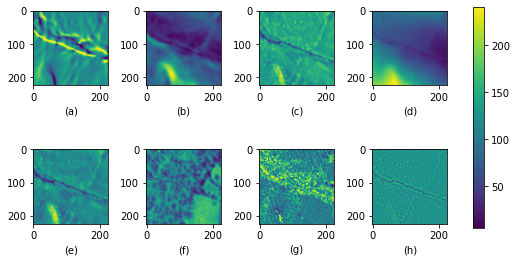

In [5]:
fig, axs = plt.subplots(2, 4,figsize=(8,4))
fig.tight_layout()
labels = ["a","b","c","d","e","f","g","h"]
count = 0
img_order = [0,1,2,3,4,5,6,7]
for ax in axs.flat:
  image = X_train[3,:,:,img_order[count]]
  im = ax.imshow(image)
  ax.set_xlabel("("+labels[count]+")", fontsize = 10) # X label
  count = count + 1

fig.colorbar(im, ax=axs.ravel().tolist() , shrink=0.9)
plt.show()

## Create U-net Model 

In [6]:
# Avaiable backbones for U-net architechture
# 'vgg16' 'vgg19' 'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152' 'inceptionv3' 
# 'inceptionresnetv2' 'densenet121' 'densenet169' 'densenet201' 'seresnet18' 'seresnet34' 
# 'seresnet50' 'seresnet101' 'seresnet152'
backend = 'vgg19'

# Fine-tuning flag
finetune = True

# TensorBoard log
logdir = log_path+backend
os.makedirs(logdir, exist_ok=True)

# define hyperparameters and callback modules
patience = 10
maxepoch = 10
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience, min_lr=1e-9, verbose=1, mode='min'),
             EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
             ModelCheckpoint(model_path+backend+'.h5', monitor='val_loss', save_best_only=True, verbose=0),
             TensorBoard(log_dir=logdir)]

### **Scenario 1:**

Create a U-net model **without** ImageNet pre-trained weights. The model input has 8 raster layers. 

**Note:** All backbones have weights trained on 2012 ILSVRC ImageNet datase (encoder_weights='imagenet').

In [16]:
# Unet with ImageNet backends
# base_model = sm.Unet(backend, classes = 1, encoder_weights=None, input_shape=(None, None, 8), encoder_freeze = False )

### **Scenario 2:**

Create a U-net model **with** ImageNet pre-trained weights. The model input has 8 raster layers. 

In this case, the backbones are trained with RGB (ImageNet) so we need to add new input wiht 8 channels. A Conv2D layer will convert 8 channels input to 3 channels input for the pretrained backbones.

In [7]:
pretrained_model = sm.Unet(backend, classes = 1, encoder_weights = 'imagenet', encoder_freeze = finetune)

input = Input(shape=(None, None, 8))
l1 = Conv2D(3, (1, 1))(input) # map N channels data to 3 channels
out = pretrained_model(l1)
base_model = Model(input, out, name = pretrained_model.name)

In [8]:
base_model.compile(optimizer = Adam(), 
                loss = dice_coef_loss, 
                metrics=[dice_coef,'accuracy'])

## Train the model

In [9]:
train_history = base_model.fit(x = X_train,y = Y_train, 
                          validation_data = (X_validation, Y_validation), 
                          batch_size = 4, epochs = maxepoch, verbose=1, callbacks = callbacks)

Epoch 1/10
13/13 [==============================] - 36s 3s/step - loss: -0.1836 - dice_coef: 0.1826 - accuracy: 0.7206 - val_loss: -0.1220 - val_dice_coef: 0.1229 - val_accuracy: 0.2213 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 35s 3s/step - loss: -0.2809 - dice_coef: 0.2792 - accuracy: 0.8002 - val_loss: -0.1448 - val_dice_coef: 0.1457 - val_accuracy: 0.3616 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 35s 3s/step - loss: -0.3841 - dice_coef: 0.3812 - accuracy: 0.8789 - val_loss: -0.2377 - val_dice_coef: 0.2376 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 34s 3s/step - loss: -0.4939 - dice_coef: 0.4896 - accuracy: 0.9224 - val_loss: -0.1642 - val_dice_coef: 0.1647 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 5/10
13/13 [==============================] - 35s 3s/step - loss: -0.5763 - dice_coef: 0.5723 - accuracy: 0.9402 - val_loss: -0.2857 - val_dice_coef: 0.2840 - val_accuracy: 0.8104 - lr: 0.0010
Epoch

## Fine-tuning 



In [19]:
# In the case that you want to run fine-tuning process, set the fintune flag to True and run this block.
if(finetune):

  # For fine-tuning we need to set the tranable flag to true for the whole model
  base_model.trainable = True

  # Recompile the model with the smaller learning rate at the optimizer (Adam(1e-5))
  base_model.compile(optimizer = Adam(1e-5), loss = dice_coef_loss, metrics=[dice_coef,'accuracy'])

  # train the model again
  train_history_2 = base_model.fit(x = X_train, y = Y_train,
                              validation_data=(X_validation, Y_validation),
                              batch_size=4,epochs=maxepoch+10,
                              initial_epoch = len(train_history.history['val_loss'])-1,
                              verbose=1 ,callbacks=callbacks)

Epoch 10/20
13/13 [==============================] - 137s 10s/step - loss: -0.6707 - dice_coef: 0.6681 - accuracy: 0.9497 - val_loss: -0.5403 - val_dice_coef: 0.5359 - val_accuracy: 0.9392 - lr: 1.0000e-05
Epoch 11/20
13/13 [==============================] - 127s 10s/step - loss: -0.6835 - dice_coef: 0.6812 - accuracy: 0.9513 - val_loss: -0.5565 - val_dice_coef: 0.5519 - val_accuracy: 0.9403 - lr: 1.0000e-05
Epoch 12/20
13/13 [==============================] - 127s 10s/step - loss: -0.6763 - dice_coef: 0.6721 - accuracy: 0.9516 - val_loss: -0.5718 - val_dice_coef: 0.5670 - val_accuracy: 0.9429 - lr: 1.0000e-05
Epoch 13/20
13/13 [==============================] - 119s 9s/step - loss: -0.6757 - dice_coef: 0.6718 - accuracy: 0.9507 - val_loss: -0.5840 - val_dice_coef: 0.5790 - val_accuracy: 0.9451 - lr: 1.0000e-05
Epoch 14/20
13/13 [==============================] - 115s 9s/step - loss: -0.6717 - dice_coef: 0.6684 - accuracy: 0.9515 - val_loss: -0.5958 - val_dice_coef: 0.5905 - val_accura

## Visualize the training performance

We setup the TensorBoard to monitor and record the training process information. 

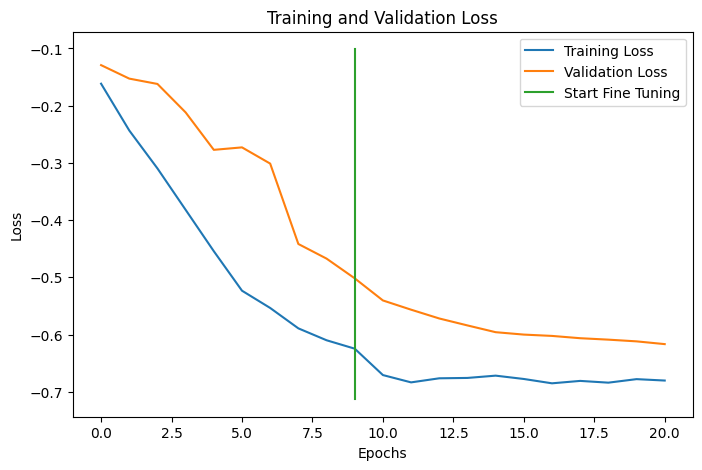

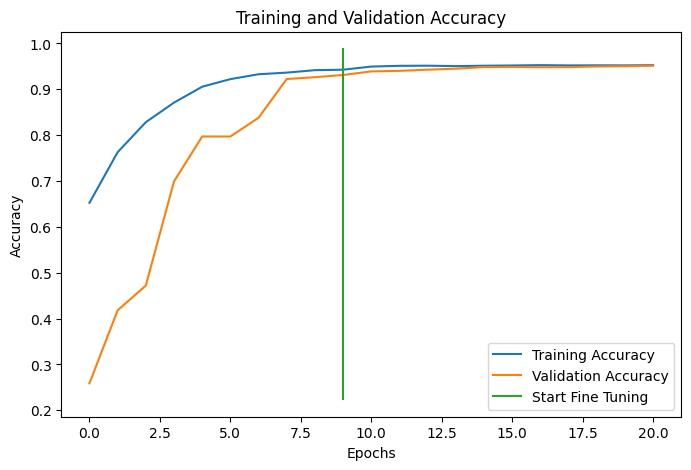

In [20]:
# Assuming you have the training history stored in a variable named 'history'
loss = train_history.history['loss'] + train_history_2.history['loss']
val_loss = train_history.history['val_loss'] + train_history_2.history['val_loss']
accuracy = train_history.history['accuracy'] + train_history_2.history['accuracy']
val_accuracy = train_history.history['val_accuracy'] + train_history_2.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([10-1,10-1],plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot([10-1,10-1],plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluate the model

The best model is automatically saved during the training (model.fit()) with the callback funtions. The saved model is in the .h5 format. Therefore, we have to load the saved model for the evaluation process.

In [21]:
# Load the best model saved by the callback module
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score,recall_score

best_model = load_model(model_path+backend+'.h5',
                        custom_objects={'dice_coef_loss':dice_coef_loss,
                                        'dice_coef':dice_coef,})

# load the test data
X_test = np.load(input_data+'test_data.npy').astype(np.float32)

# predict the test data using the loaded model
test_predicted= best_model.predict(X_test)

# convert the prediction probability to true or false with threshold at 0.5
test_predicted_threshold = (test_predicted > 0.5).astype(np.uint8)

y_true_f = K.flatten(Y_test.astype(np.uint8))
y_pred_f = K.flatten(test_predicted_threshold.astype(np.uint8))

f1_stream = f1_score(y_true_f, y_pred_f,labels=[1], average = 'micro')
precision_stream = precision_score(y_true_f, y_pred_f,labels=[1], average = 'micro')
recall_stream = recall_score(y_true_f, y_pred_f,labels=[1], average = 'micro')

print('Model path:' + model_path + backend)
print('F1 score of Stream: '+str(f1_stream))
print('Precision of Stream: '+str(precision_stream))
print('Recall of Stream: '+str(recall_stream))

2/2 [==============================] - 21s 8s/step
Model path:./models/vgg19
F1 score of Stream: 0.6146031041601453
Precision of Stream: 0.6195794586648772
Recall of Stream: 0.6097060511482009


<Figure size 800x500 with 0 Axes>

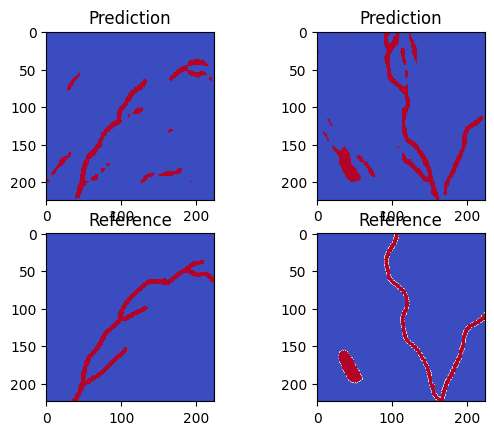

In [22]:
plt.figure(figsize=(8, 5))
f, axarr = plt.subplots(2,2) 
axarr[0,0].imshow(test_predicted_threshold[2], cmap = 'coolwarm', interpolation='nearest')
axarr[0,0].title.set_text('Prediction')
axarr[1,0].imshow(Y_test[2], cmap = 'coolwarm', interpolation='nearest')
axarr[1,0].title.set_text('Reference')

axarr[0,1].imshow(test_predicted_threshold[4], cmap = 'coolwarm', interpolation='nearest')
axarr[0,1].title.set_text('Prediction')
axarr[1,1].imshow(Y_test[4], cmap = 'coolwarm', interpolation='nearest')
axarr[1,1].title.set_text('Reference')